In [96]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

In [97]:
#importing data
raw_data = pd.read_csv(r"C:\Users\USER\Crime_Data_from_2020_to_Present.csv")

data = raw_data.copy()

#Renaming all columns(on the copy)
data.columns = ['File_Number','Report_Date','Occ_Date','Occ_Time','Area_Code','Area_Name',
                'Sub_Area_Code','Crime_degree','Crime_Code','Crime_Desc','Mocodes','Vict_Age',
                'Vict_Sex','Vict Descent','Place_code','Place_Desc','Weapon_code','Weapon_Desc',
                'Status','Status_Desc','crime_1','crime_2','crime_3','crime_4','Location',
                'Cross_Street','LAT','LON'
               ]

#settings
pd.set_option("display.max_columns",30)

### Column Dtypes Fix: 

In [98]:
# Fixing date columns dtypes
data['Report_Date'] = pd.to_datetime(data["Report_Date"])
data['Occ_Date'] = pd.to_datetime(data["Occ_Date"])

In [99]:
# Fixing Time column 
data['Occ_Time'] = data['Occ_Time'].astype('str').str.zfill(4)
data['Occ_Time'] = data['Occ_Time'].str[:2] +":"+ data['Occ_Time'].str[2:]
data['Occ_Time'] = pd.to_datetime(data["Occ_Time"],format = "%H:%M").dt.time
#adding an hour column
data["Occ_Hour"] = data["Occ_Time"].astype('str').str[:2]

In [100]:
#Converting catagorical columns into category dtype

# before 164.7+ MB

for column in data.columns:
    if data[column].nunique() <25:
        data[column] = data[column].astype('category')
    else:
        data[column] = data[column]
        
# after 123.5+ MB

In [250]:
#Makind File_Number More readable
data = data.sort_values(by = 'Report_Date').reset_index(drop = True)
data['File_Number'] = [i.zfill(6) for i in np.arange(0,770787).astype('str')]

# Fact:

In [248]:
#Orgenazing The Data into Tables
Fact = data[['File_Number','Report_Date','Occ_Date','Occ_Time','Area_Code','Sub_Area_Code','Crime_degree','Crime_Code','Status','LAT','LON']]

# Dim:

In [252]:
#Orgenazing The Data into Tables
Dim_Area = data[['Area_Code','Area_Name']].sort_values(by = 'Area_Code').reset_index(drop = True)

Dim_Sub_Area = data[['Sub_Area_Code','Area_Name']].sort_values(by = 'Sub_Area_Code').reset_index(drop = True)

Dim_Crime = data[['Crime_Code','Crime_Desc']].drop_duplicates().sort_values(by = 'Crime_Code').reset_index(drop = True)

Dim_Sub_Crime = data[['File_Number','Crime_Code','crime_2','crime_3','crime_4']]

Dim_Status = data[['Status','Status_Desc']].drop_duplicates().sort_values(by = 'Status').reset_index(drop = True)

Dim_Weapon = data[['File_Number','Weapon_code','Weapon_Desc']].dropna(how = 'any').reset_index(drop = True)

#information about the Place (Place Description)
Dim_Place = data[['Place_code','Place_Desc']]
Dim_Place = Dim_Place.dropna(how = 'any').drop_duplicates()
Dim_Place['Place_code'] = Dim_Place['Place_code'].astype('int16')
Dim_Place = Dim_Place.sort_values(by = 'Place_code').reset_index(drop = True)

#information about the victim (age, sex, Descent)
Dim_Victim = data[['File_Number','Vict_Age','Vict_Sex','Vict Descent']]

#information about the geographical place 
Dim_Geographic = data[['Location','Area_Name']].drop_duplicates().sort_values(by = 'Area_Name').reset_index(drop = True)

Dim_Coordinates = data[['File_Number','LAT','LON']]

Dim_LON = pd.DataFrame({"LON_ID":np.arange(10,len(Dim_Coordinates['LON'].unique())+10),"LON":Dim_Coordinates['LON'].unique()})
Dim_LAT = pd.DataFrame({"LAT_ID":np.arange(10,len(Dim_Coordinates['LAT'].unique())+10),"LAT":Dim_Coordinates['LAT'].unique()})

#Replacing LAT and LON Values with the New codes
Fact = Fact.merge(Dim_LON,on = 'LON').merge(Dim_LAT,on = 'LAT').sort_values(by = 'File_Number').reset_index(drop = True).drop(['LAT','LON'],axis = 1)

In [254]:
#Creating a date table
Dim_Date = pd.DataFrame({"Date":pd.date_range(start=Fact['Report_Date'].min(),end=Fact['Report_Date'].max())})

Dim_Date['year'] = Dim_Date['Date'].dt.year
Dim_Date['month'] = Dim_Date['Date'].dt.month
Dim_Date['Day'] = Dim_Date['Date'].dt.day

 
Dim_Date['Week_Day'] =Dim_Date['Date'].dt.dayofweek + 2
#sunday = 1, Saturday = 7
Dim_Date['Week_Day'] = np.where(Dim_Date['Week_Day'] == 8 ,1,Dim_Date['Week_Day'])

Dim_Date['Day_Name'] = Dim_Date['Date'].dt.day_name()


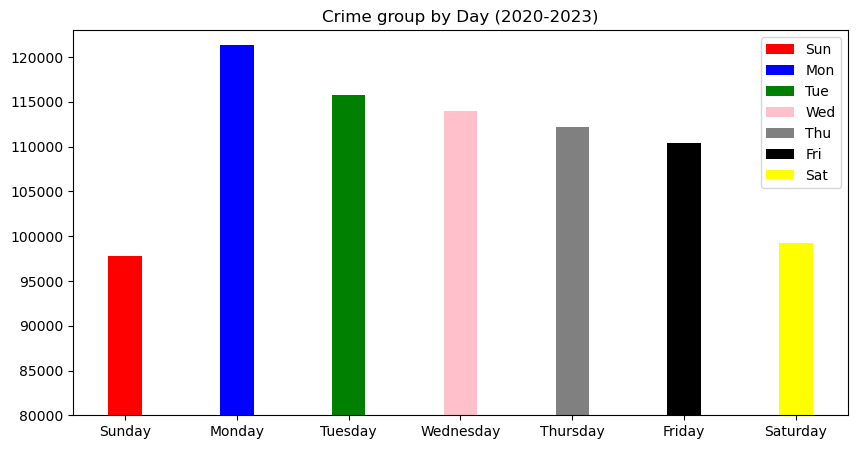

In [365]:
# מה היום והשעה עם אחוז הפשעים הגבוהה ביותר
fact_dayname = Fact[['File_Number','Report_Date','Occ_Time']].merge(Dim_Date[['Date','Day_Name','Week_Day']],how = 'left', left_on='Report_Date',right_on= 'Date')
crime_for_day = fact_dayname.groupby(['Day_Name','Week_Day'])['File_Number'].count().reset_index()
crime_for_day = crime_for_day.sort_values(by = 'Week_Day')
X = crime_for_day['Day_Name']
Y = crime_for_day['File_Number']


figure = plt.figure(figsize = (10,5))
plt.ylim(80000,123000)
plt.bar(X,Y,color = ['r','b','g','pink','gray','black','yellow'],label = [day[:3] for day in crime_for_day['Day_Name'].tolist()],width=0.3)
plt.legend()
plt.title("Crime group by Day (2020-2023)")

plt.show()